# Ocena jakości klasyfikacji dla zbiorów niezbilansowanych.

**Wstęp**

Cukrzyca jest chorobą metaboliczną, stanowiącą globalny problem zdrowotny, wpływając na miliony
ludzi na całym świecie. To schorzenie, charakteryzujące się zaburzeniami gospodarki insulinowej, ma
istotny wpływ na jakość życia pacjentów oraz zwiększa ryzyko powikłań zdrowotnych.

**Cel**

W niniejszym projekcie skupimy się na analizie danych medycznych pacjentów, starając się
zrozumieć, jak różne cechy wpływają na ryzyko wystąpienia cukrzycy. Tym samym ocenimy jakość metod resamplingu w klasyfikacji niezbilansowanych zbiorów danych. 

# Wczytanie niezbędnych bibliotek oraz danych

In [2]:
import matplotlib.pyplot as plt
import shap
import dalex
import yellowbrick
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from dalex import Explainer
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import Image
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('diabetes.csv', sep=',', decimal=',')

# Wstępna analiza danych

In [3]:
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Pregnancies               768 non-null    int64 
 1   Glucose                   768 non-null    int64 
 2   BloodPressure             768 non-null    int64 
 3   SkinThickness             768 non-null    int64 
 4   Insulin                   768 non-null    int64 
 5   BMI                       768 non-null    object
 6   DiabetesPedigreeFunction  768 non-null    object
 7   Age                       768 non-null    int64 
 8   Outcome                   768 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 54.1+ KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
212,7,179,95,31,0,34.2,0.164,60,0
188,8,109,76,39,114,27.9,0.64,31,1
652,5,123,74,40,77,34.1,0.269,28,0
349,5,0,80,32,0,41,0.346,37,1
442,4,117,64,27,120,33.2,0.23,24,0
532,1,86,66,52,65,41.3,0.917,29,0
364,4,147,74,25,293,34.9,0.385,30,0
288,4,96,56,17,49,20.8,0.34,26,0
13,1,189,60,23,846,30.1,0.398,59,1
452,0,91,68,32,210,39.9,0.381,25,0


Zbiór danych składa się z 768 obserwacji, porównanych pod względem 9 zmiennych. W zbiorze można zaobserwować zmienne numeryczne (np. pregnancies, glucose, blood pressure, skin thickness, insluin, age, BMI) oraz kategoryczne (np. diabetes pedigree function). W zbiorze zebrano 8 zmiennych, które mogą mieć wpływ na wystąpienie cukrzycy u badanych. Na ich podstawie będziemy próbować przewidzieć, czy dana osoba jest chora na cukrzycę, czyli przewidzieć wartość zmiennej objaśnianej outcome.

# Szukanie braków danych

In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Brakujące wartości mogą stanowić wyzwanie dla modelu, wpływając negatywnie na jego skuteczność. W przypadku ich obecności konieczne jest usunięcie tych danych lub zastąpienie wartości NaN średnią lub medianą. W analizowanym zbiorze danych nie występują braki.

# Przekształcenie kolumn BMI i DiabetesPedigreeFunction

In [3]:
#df = pd.DataFrame(data)

#df['BMI'] = pd.to_numeric(data['BMI'], errors='coerce')
#df['DiabetesPedigreeFunction'] = pd.to_numeric(data['DiabetesPedigreeFunction'], errors='coerce')

data['BMI'] = pd.to_numeric(data['BMI'], errors='coerce')
data['DiabetesPedigreeFunction'] = pd.to_numeric(data['DiabetesPedigreeFunction'], errors='coerce')

In [6]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Przekształcenie zmiennych typu object na float64 obejęło konwersję wartości nieliczbowych na liczby zmiennoprzecinkowe. Wartości, które pierwotnie były reprezentowane jako tekst, zostały zidentyfikowane, po czym poddane procesowi konwersji. Takie podejście jest często stosowane w analizie danych, zwłaszcza przygotowując dane do uczenia maszynowego.

# Opis zmiennych

**Zmienne objaśniające:**

- Pregnancies - liczba ciąż u pacjentki
- Glucose - poziom glukozy we krwi
- BloodPressure - ciśnienie krwi
- SkinThickness - grubość skóry
- Insulin - poziom insuliny we krwi
- BMI - indeks masy ciała
- DiabetesPedigreeFunction - szansa wystąpienia cukrzycy w rodzinie
- Age - wiek pacjenta

**Zmienna objaśniana:**

- Outcome - czy badany cierpi na cukrzycę; 0 - nie, 1 - tak

# Podstawowe statystyki opisowe

In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Zbiór danych obejmuje osoby w wieku od 21 do 81 lat, ze średnią wieku wynoszącą około 33 lata. Dla badanych pacjentów średni poziom glukozy we krwi wyniósł 120.89 mg/dl, ciśnienia krwi - 69.11 mmHG, a insuliny we krwi - 79.8 mU/ml. Przy średniej grubości skóry wynoszącej 15.95 cm, można zaobserwować średnie BMI na poziomie 32. Spośród pacjentek, średnia liczba ciąż to około 4. Szansa wystąpienia cukrzycy w rodzinie to 47% przy zapadalności na cukrzycę, wynoszącej średnio około 35%.

# Wpływ poszczególnych zmiennych na zmienną prognozowaną Outcome

Największe korelacje ze zmienną 'Outcome':
Glucose: 0.47
BMI: 0.29
Age: 0.24
Pregnancies: 0.22
Najmniejsze korelacje ze zmienną 'Outcome':
BloodPressure: 0.07
SkinThickness: 0.07
Insulin: 0.13
DiabetesPedigreeFunction: 0.17


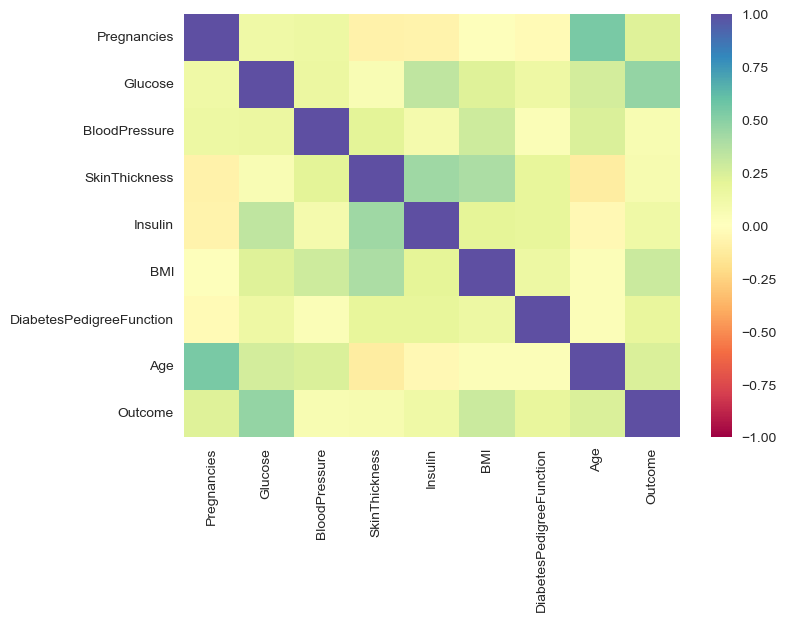

In [8]:
sns.heatmap(data.corr(), cmap='Spectral',
center=0, vmin=-1, vmax=1)

max_corr_values = data.corr()['Outcome'].abs().drop('Outcome').nlargest(4)
max_corr_indices = max_corr_values.index

print(f"Największe korelacje ze zmienną 'Outcome':")
for idx in max_corr_indices:
    max_corr_value = data.corr()['Outcome'][idx]
    print(f"{idx}: {max_corr_value:.2f}")
    
min_corr_values = data.corr()['Outcome'].abs().drop('Outcome').nsmallest(4)
min_corr_indices = min_corr_values.index

print(f"Najmniejsze korelacje ze zmienną 'Outcome':")
for idx in min_corr_indices:
    min_corr_value = data.corr()['Outcome'][idx]
    print(f"{idx}: {min_corr_value:.2f}")

**Największe korelacje zmiennych to:**

*Glucose:* 0.47 - Istnieje umiarkowana pozytywna korelacja między poziomem glukozy a wystąpieniem cukrzycy. Wyższe wartości glukozy są związane z większym prawdopodobieństwem wystąpienia cukrzycy. 

*BMI:* 0.29 - Istnieje średnia pozytywna korelacja między wskaźnikiem masy ciała (BMI) a wystąpieniem cukrzycy. Wyższe wartości BMI są związane z większym ryzykiem cukrzycy. 

*Age:* 0.24 - Wiek pacjenta ma umiarkowanie pozytywną korelację z cukrzycą. Starsze osoby mogą być bardziej narażone na cukrzycę. 

*Pregnancies:* 0.22 - Liczba ciąż ma niską pozytywną korelację z cukrzycą. Wysoka liczba ciąż może nieco zwiększać ryzyko cukrzycy.

**Najmniejsze korelacje to:**

*BloodPressure:* 0.07 - Ciśnienie krwi ma bardzo niską pozytywną korelację z cukrzycą. Nie ma silnego związku między ciśnieniem krwi a cukrzycą. 

*SkinThickness:* 0.07 - Grubość skóry ma również bardzo niską pozytywną korelację z cukrzycą. 

*Insulin:* 0.13 Poziom insuliny ma niską pozytywną korelację z cukrzycą. 

*DiabetesPedigreeFunction:* 0.17 - Wartość funkcji rodowodu cukrzycowego ma niską pozytywną korelację z cukrzycą.

**Podsumowując,** wyniki sugerują, że poziom glukozy, BMI i wiek są bardziej powiązane z wystąpieniem cukrzycy w porównaniu do innych zmiennych. Natomiast ciśnienie krwi, grubość skóry, poziom insuliny i wartość funkcji rodowodu cukrzycowego mają mniejszy wpływ na prognozowanie cukrzycy, choć nadal mogą mieć pewne znaczenie.

# Wartości odstające

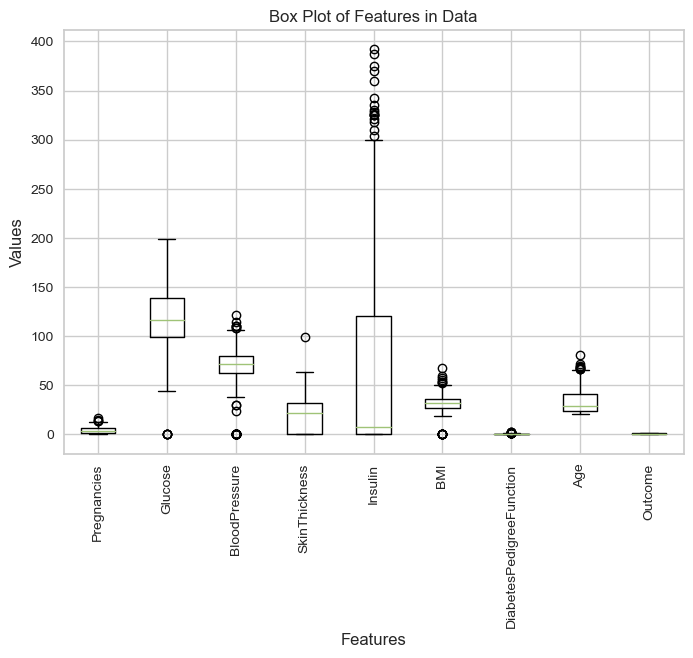

In [9]:
data_dropped_outliers = data[(data['Insulin'])<400]
plt.boxplot(data_dropped_outliers.values, labels=data_dropped_outliers.columns)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box Plot of Features in Data')

plt.savefig('box_plot.png')
plt.show()

data = data_dropped_outliers

Usunięto z zestawu danych wartości dla zmiennej Insulin przekraczające 400 ze względu na możliwy wpływ obecności wartości odstających na efektywność modeli, zwłaszcza tych podatnych na skrajne wartości.

# Liczność poszczególnych klas

In [10]:
data['Outcome'].value_counts()

0    492
1    256
Name: Outcome, dtype: int64

Zbiór danych jest niezbalansowany, z większą liczbą przypadków bez cukrzycy (Outcome=0), co może wpływać na wydajność modeli uczenia maszynowegostąd dostosowanie strategii klasyfikacji poprzez undersampling, czyli zmniejszenia liczby przypadków w klasie dominującej do liczby przypadków w mniej licznej klasie.

In [4]:
data_sorted = data.groupby('Outcome')
minSize = data_sorted.size().min()
data_balanced = data_sorted.apply(lambda x: x.sample(minSize, random_state=21)).reset_index(drop=True)
data_balanced['Outcome'].value_counts()

0    268
1    268
Name: Outcome, dtype: int64

Zbalansowany zbiór danych składa się z 512 obserwacji, z których 256 stanowią osoby z cukrzycą jak i bez. Zbalansowany zbiór danych zapobiega stronniczości modelu w kierunku dominującej klasy. Model, trenowany na zbalansowanym zbiorze danych, nie będzie skłonny do faworyzowania jednej klasy kosztem innych. Zbalansowany zbiór danych umożliwia modelowi uzyskanie lepszej ogólnej wydajności, ponieważ ma równą reprezentację wszystkich klas. To z kolei może prowadzić do lepszej dokładności predykcji na rzeczywistych danych.

# Zalety i wady undersamplingu:

**Zalety:**

Szybkość treningu - ponieważ liczba przypadków jest mniejsza, modele trenują się zazwyczaj szybciej.

Redukcja szumu - usunięcie nadmiarowych przypadków z dominującej klasy może pomóc w redukcji zakłóceń i szumu związanych z niezrównoważeniem.


**Wady:**

Utrata informacji - usuwanie przypadków z dominującej klasy może prowadzić do utraty informacji, co może wpływać na zdolność modelu do generalizacji.

# Podział danych na zbiór uczący i testowy

In [5]:
X = data.drop(columns=['Outcome'])
Y = data['Outcome']
cols = [k for k in data_balanced.columns if k != 'Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    data_balanced[cols],
    data_balanced['Outcome'],
    test_size=0.3,
    random_state=21
)
print((data_balanced[cols]))

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              2      146             76             35      194  38.2   
1             10       94             72             18        0  23.1   
2              1      144             82             40        0  41.3   
3              0      107             76              0        0  45.3   
4              4      128             70              0        0  34.3   
..           ...      ...            ...            ...      ...   ...   
531            4      132              0              0        0  32.9   
532            2      155             74             17       96  26.6   
533            0      105             84              0        0  27.9   
534            4      136             70              0        0  31.2   
535            1      173             74              0        0  36.8   

     DiabetesPedigreeFunction  Age  
0                       0.329   29  
1                       0.595   56  


# Standaryzacja

In [13]:
# Inicjalizacja scalera
scaler = StandardScaler()

# Dostosowanie scalera do danych treningowych
scaler.fit(X_train)

# Skalowanie danych treningowych i testowych
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Obliczanie średniej i odchylenia standardowego dla przeskalowanych danych treningowych
mean_values = np.mean(X_train_scaled, axis=0)
std_values = np.std(X_train_scaled, axis=0)

print("Średnie dla przeskalowanych danych treningowych:")
print(mean_values)

print("\nOdchylenia standardowe dla przeskalowanych danych treningowych:")
print(std_values)

Średnie dla przeskalowanych danych treningowych:
[-3.96951249e-17 -1.19085375e-16  1.77387589e-16 -9.42759216e-17
  0.00000000e+00 -3.90748886e-17 -3.72141796e-17 -4.71379608e-17]

Odchylenia standardowe dla przeskalowanych danych treningowych:
[1. 1. 1. 1. 1. 1. 1. 1.]


Standaryzacja to proces przetwarzania danych, który sprowadza je do wspólnej skali, eliminując jednocześnie zniekształcenia wynikające z różnic w zakresach cech. W przypadku algorytmu KNN, normalizacja odgrywa kluczową rolę. Jeśli cechy nie są dostosowane do wspólnej skali, te o większym zakresie będą miały większy wpływ na prognozy niż te o mniejszym zakresie. Ta nierówna waga może prowadzić do niedokładnych prognoz i stronniczych wyników. Normalizacja gwarantuje, że wszystkie cechy mają równy wpływ, co skutkuje obiektywnymi i nieuprzedzonymi prognozami. W przypadku drzew decyzyjnych i lasu losowego, standaryzacja danych nie jest konieczna.

# Model KNN

k: 1, Test accuracy: 0.7142857142857143, Train accuracy: 1.0
k: 2, Test accuracy: 0.6753246753246753, Train accuracy: 0.8379888268156425
k: 3, Test accuracy: 0.6558441558441559, Train accuracy: 0.8324022346368715
k: 4, Test accuracy: 0.6493506493506493, Train accuracy: 0.8212290502793296
k: 5, Test accuracy: 0.6753246753246753, Train accuracy: 0.8240223463687151
k: 6, Test accuracy: 0.6363636363636364, Train accuracy: 0.8044692737430168
k: 7, Test accuracy: 0.6688311688311688, Train accuracy: 0.8072625698324022
k: 8, Test accuracy: 0.6623376623376623, Train accuracy: 0.7960893854748603
k: 9, Test accuracy: 0.7207792207792207, Train accuracy: 0.7932960893854749
k: 10, Test accuracy: 0.6753246753246753, Train accuracy: 0.7793296089385475
k: 11, Test accuracy: 0.7402597402597403, Train accuracy: 0.7905027932960894
k: 12, Test accuracy: 0.7012987012987013, Train accuracy: 0.7932960893854749
k: 13, Test accuracy: 0.7142857142857143, Train accuracy: 0.7821229050279329
k: 14, Test accuracy: 0

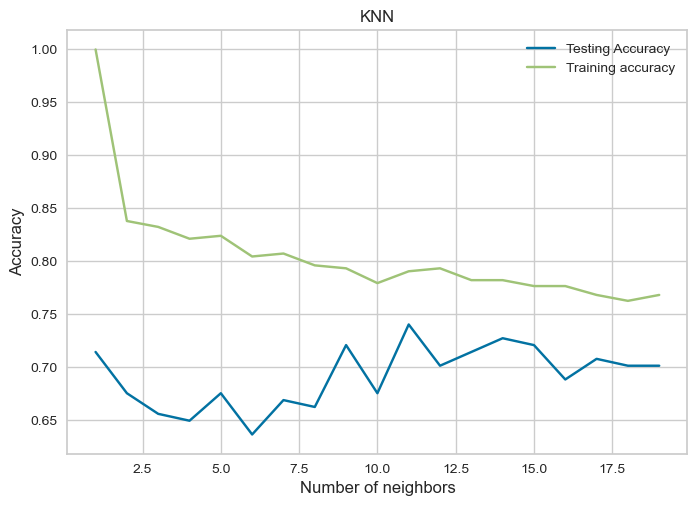

In [14]:
neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracy[i] = knn.score(X_train_scaled, y_train)
    test_accuracy[i] = knn.score(X_test_scaled, y_test)
    print(f"k: {k}, Test accuracy: {test_accuracy[i]}, Train accuracy: {train_accuracy[i]}")

plt.title('KNN')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Dla mniejszych wartości k, zwiększenie liczby k powoduje zmniejszenie dokładności dla zestawu uczącego, natomiast dla zestawu testowego prowadzi do jej zwiększenia. Wyniki te wskazują na to, że dla mniejszych k model jest nadmiernie dopasowany (przetrenowany). Po osiągnięciu pewnego progu, dokładność modelu przestaje znacząco się zmieniać. Optymalna wartość k wynosi 11; zbyt duże wartości mogą prowadzić do nadmiernego uogólnienia modelu, czyli niedotrenowania. Warto również zauważyć, że zaleca się używanie liczby k o nieparzystej wartości, aby uniknąć sytuacji remisowej w klasyfikacji.

# Macierz błędów i jakość klasyfikacji KNN

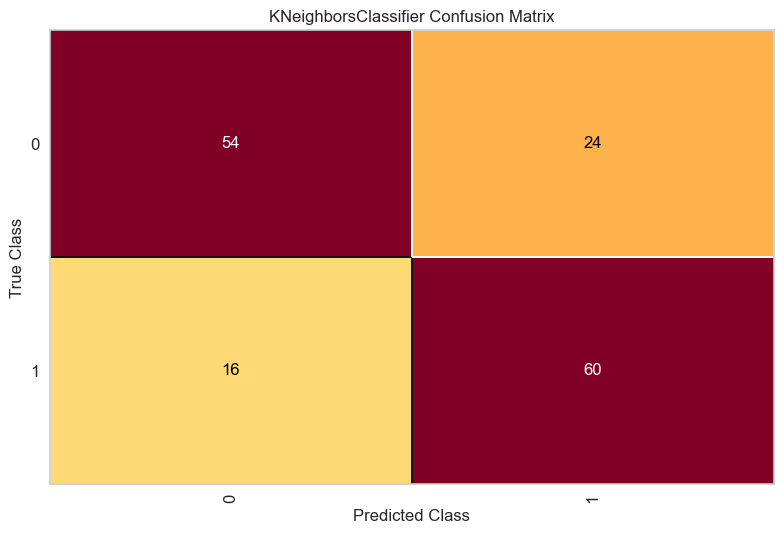

              precision    recall  f1-score   support

           0       0.77      0.69      0.73        78
           1       0.71      0.79      0.75        76

    accuracy                           0.74       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.74      0.74      0.74       154



In [15]:
chosen_k = 11
knn_scaled = KNeighborsClassifier(n_neighbors=chosen_k)
cm1 = ConfusionMatrix(knn_scaled)
cm1.fit(X_train_scaled, y_train)
accuracy = cm1.score(X_test_scaled, y_test)
cm1.show()

y_pred_scaled = knn_scaled.predict(X_test_scaled)
report = classification_report(y_test, y_pred_scaled)
print(report)

**Dla ustandaryzowanych danych model KNN przyjmuje:**

- Precyzja (Precision):
  - Dla klasy 0 (negatywnej): 0.77 - 77% przypadków sklasyfikowanych jako negatywne są prawidłowe..
  - Dla klasy 1 (pozytywnej): 0.71 - 71% przypadków sklasyfikowanych jako pozytywne są prawidłowe.

- Czułość (Recall):
  - Dla klasy 0: 0.69 - 69% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
  - Dla klasy 1: 0.79 - 79% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
  - Dla klasy 0: 0.73 - Średnia harmoniczna precyzji i czułości dla klasy 0.
  - Dla klasy 1: 0.75 - Średnia harmoniczna precyzji i czułości dla klasy 1.
  
- Dokładność (Accuracy): 0.74 - oznacza to, że 74% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

Podsumowanie:
        Model KNN wydaje się być zrównoważony, mając porównywalnie dobre wyniki dla obu klas. Precision, recall i F1-Score są na umiarkowanym poziomie. Warto jednak zauważyć, że wyniki te zawsze zależą od konkretnego kontekstu problemu i wymagań dotyczących jakości klasyfikacji. 
        
Podsumowując, model ma zrównoważone wyniki dla obu klas, ale może być pewne polepszenie w poprawności klasyfikacji, zwłaszcza w przypadku klasy 0. 

# Model regresji logistycznej

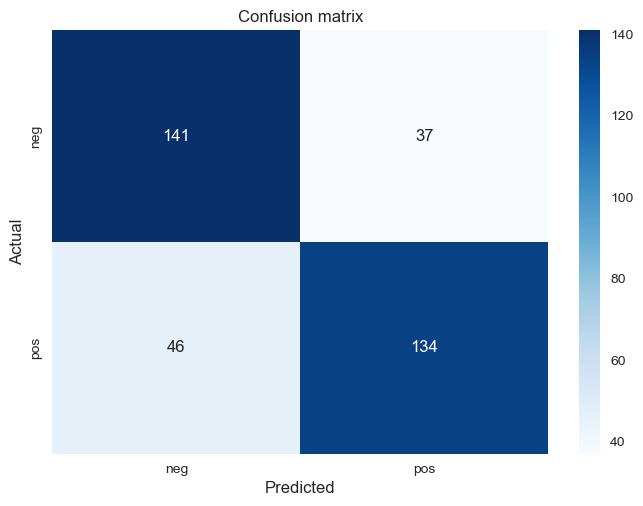

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       178
           1       0.78      0.74      0.76       180

    accuracy                           0.77       358
   macro avg       0.77      0.77      0.77       358
weighted avg       0.77      0.77      0.77       358



In [16]:
model = LogisticRegression(max_iter=10000)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred_train)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, columns=['neg', 'pos'] , index=['neg', 'pos'] )
sns.heatmap(conf_matrix_with_labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()
print(classification_report(y_train, y_pred_train))

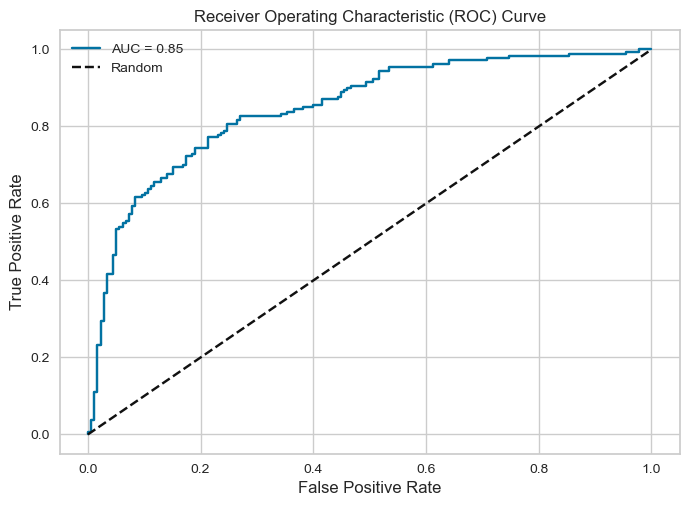

In [17]:
# Krzywa ROC
y_pred_proba = model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# AUC (Area Under the Curve)
auc = roc_auc_score(y_train, y_pred_proba)

# Wykres ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

**Miary klasyfikacji na zbiorze uczącym i testowym:**

In [18]:
print("Zbiór uczący:")
report = classification_report(y_train, y_pred_train)
print(report)


y_pred_test = model.predict(X_test)

print("Zbiór testowy:")
report = classification_report(y_test, y_pred_test)
print(report)

Zbiór uczący:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       178
           1       0.78      0.74      0.76       180

    accuracy                           0.77       358
   macro avg       0.77      0.77      0.77       358
weighted avg       0.77      0.77      0.77       358

Zbiór testowy:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75        78
           1       0.75      0.70      0.72        76

    accuracy                           0.73       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.73      0.73      0.73       154



**Dla modelu regresji logistycznej otrzymujemy:**

**Zbiór uczący:**

- Precision (Precyzja):
     - Dla klasy 0: 0.75 - 75% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
     - Dla klasy 1: 0.78 - 78% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
     - Dla klasy 0: 0.79 - 79% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
     - Dla klasy 1: 0.74 - 74% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
     - Dla klasy 0: 0.77 - Średnia harmoniczna precyzji i czułości dla klasy 0.
     - Dla klasy 1: 0.76 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 0.77 - 77% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

**Zbiór testowy:**

- Precision (Precyzja):
     - Dla klasy 0: 0.72 - 72% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
     - Dla klasy 1: 0.75 - 75% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
     - Dla klasy 0: 0.77 - 77% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
     - Dla klasy 1: 0.70 - 70% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
     - Dla klasy 0: 0.75 - Średnia harmoniczna precyzji i czułości dla klasy 0.
     - Dla klasy 1: 0.72 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 0.73 - 73% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

Podsumowanie:
    Model wydaje się dobrze radzić na zbiorze uczącym, uzyskując precyzyjne i zrównoważone wyniki dla obu klas. W zbiorze uczącym średnia ważona precyzji, czułości i F1-Score wynosi 77%, co oznacza, że wyniki są równomiernie ważone dla obu klas.
Na zbiorze testowym dokładność wynosi 73%, co sugeruje, że model ma zdolność generalizacji, ale może być pewne polepszenie w poprawności klasyfikacji, zwłaszcza dla klasy 0.
       
Modele regresji logistycznej są często używane w zadaniach klasyfikacji binarnej i interpretacja tych wskaźników pomaga zrozumieć, jak dobrze model radzi sobie w przewidywaniu obu klas.

# Drzewo decyzyjne

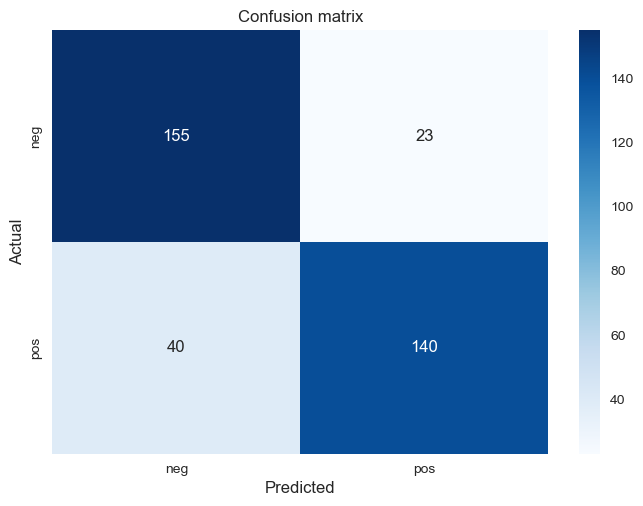

In [19]:
model3 = DecisionTreeClassifier(max_depth=4)
model3.fit(X_train, y_train)

y_pred_train = model3.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred_train)
conf_matrix_with_labels = pd.DataFrame(conf_matrix, columns=['neg', 'pos'] , index=['neg', 'pos'] )
sns.heatmap(conf_matrix_with_labels, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

**Wizualizacja modelu drzewa decyzyjnego**

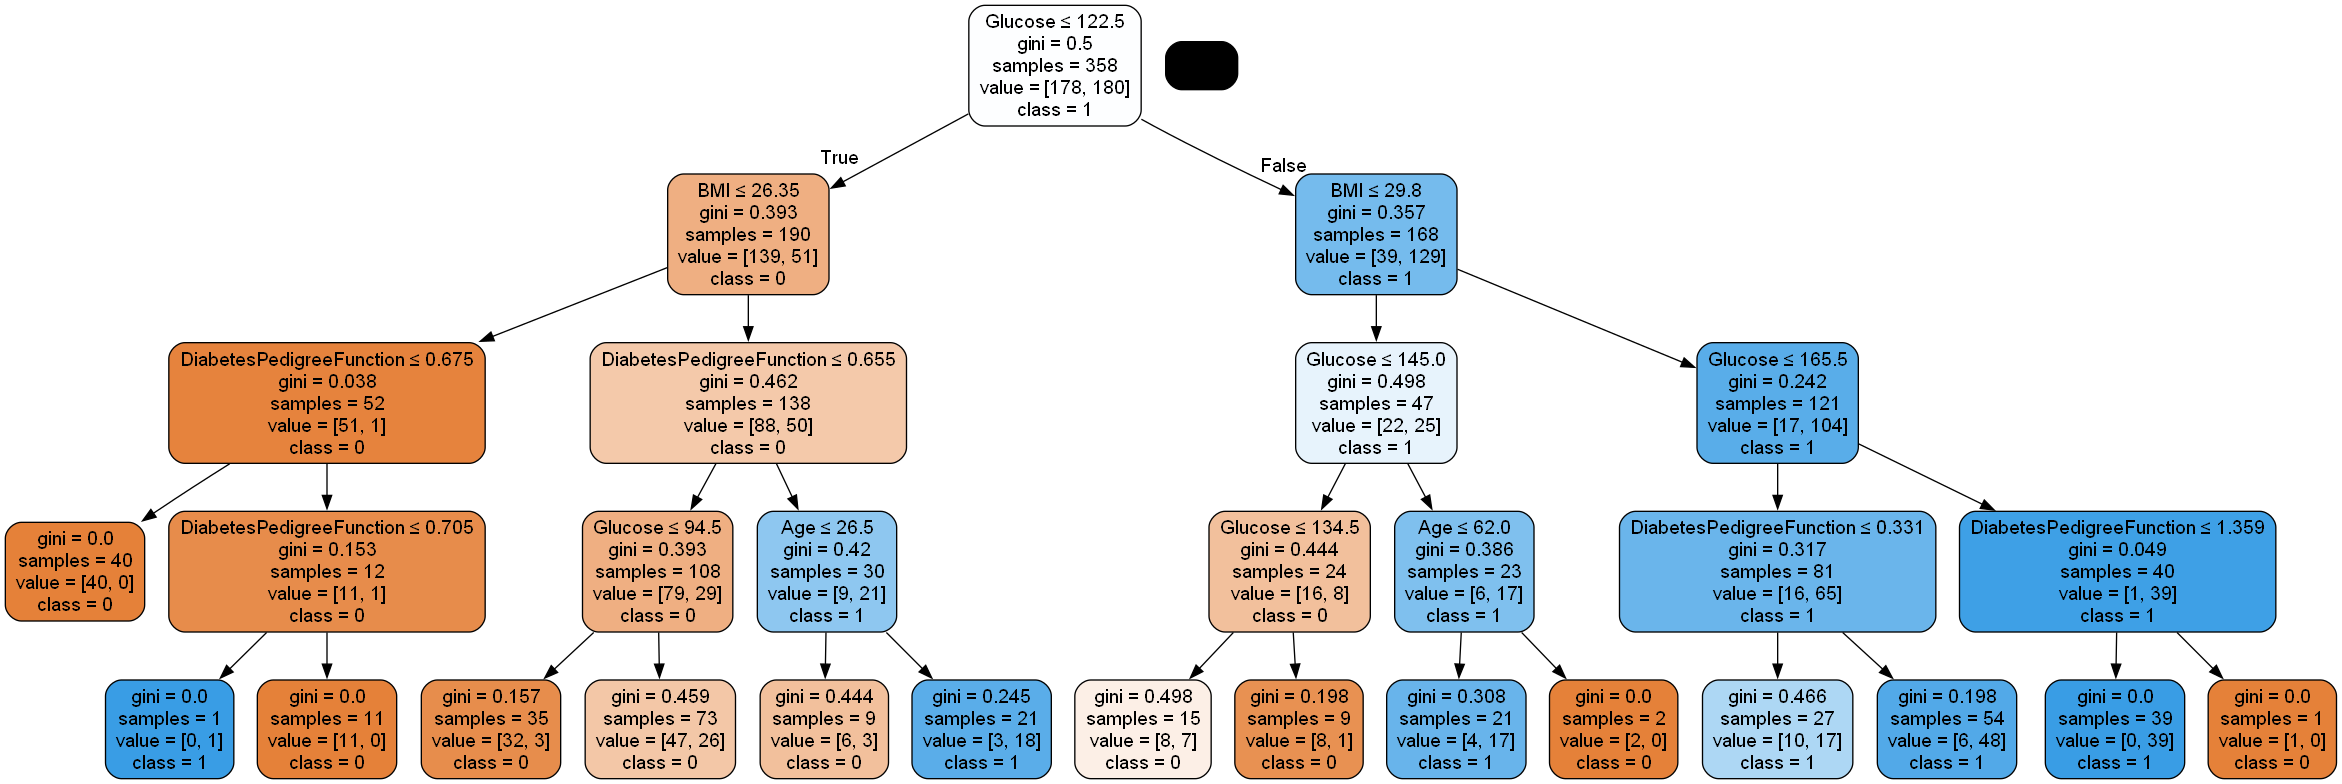

In [20]:
class_names_str = [str(class_name) for class_name in model3.classes_]
X_train_df = pd.DataFrame(X_train, columns=X.columns)

dot_data = export_graphviz(model3, out_file=None,
                           feature_names=list(X_train_df.columns),
                           class_names=class_names_str,
                           filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Miary klasyfikacji na zbiorze uczącym i testowym:**

In [21]:
print("Zbiór uczący:")
report = classification_report(y_train, y_pred_train)
print(report)


y_pred_test = model3.predict(X_test)

print("Zbiór testowy:")
report = classification_report(y_test, y_pred_test)
print(report)

Zbiór uczący:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       178
           1       0.86      0.78      0.82       180

    accuracy                           0.82       358
   macro avg       0.83      0.82      0.82       358
weighted avg       0.83      0.82      0.82       358

Zbiór testowy:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70        78
           1       0.70      0.67      0.68        76

    accuracy                           0.69       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.69      0.69      0.69       154



**Wskaźniki oceny dla drzew decyzyjnych:**

**Zbiór Uczący:**

- Precision (Precyzja):
  - Dla klasy 0: 0.79 - 79% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
  - Dla klasy 1: 0.86 - 86% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
  - Dla klasy 0: 0.87 - 87% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
  - Dla klasy 1: 0.78 - 78% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
  - Dla klasy 0: 0.83 - Średnia harmoniczna precyzji i czułości dla klasy 0.
  - Dla klasy 1: 0.82 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 0.82 - 82% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

**Zbiór Testowy:**

- Precision (Precyzja):
  - Dla klasy 0: 0.69 - 69% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
  - Dla klasy 1: 0.70 - 70% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
  - Dla klasy 0: 0.72 - 72% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
  - Dla klasy 1: 0.67 - 67% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
  - Dla klasy 0: 0.70 - Średnia harmoniczna precyzji i czułości dla klasy 0.
  - Dla klasy 1: 0.68 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 0.69 - 69% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

Podsumowanie:
    Drzewo decyzyjne uzyskuje dobre wyniki na zbiorze uczącym, jednak na zbiorze testowym widoczne jest pewne obniżenie skuteczności modelu. Może to sugerować pewne przetrenowanie lub brak zdolności do generalizacji na nowe dane

# Las losowy

Zbiór treningowy:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       187
           1       1.00      1.00      1.00       188

    accuracy                           1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



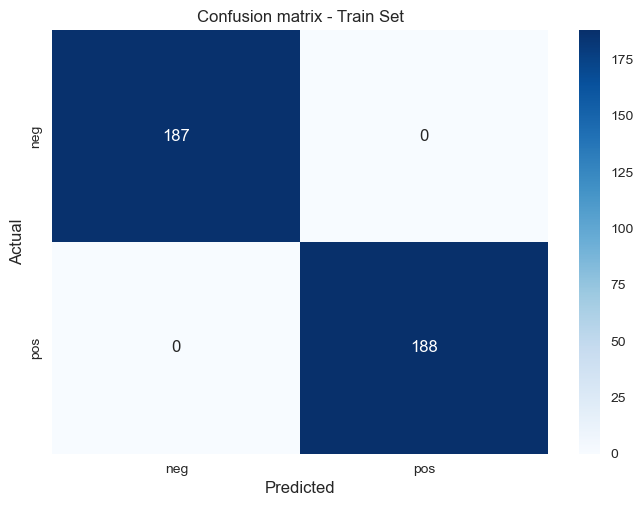

Zbiór testowy:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75        81
           1       0.76      0.71      0.74        80

    accuracy                           0.75       161
   macro avg       0.75      0.75      0.74       161
weighted avg       0.75      0.75      0.75       161



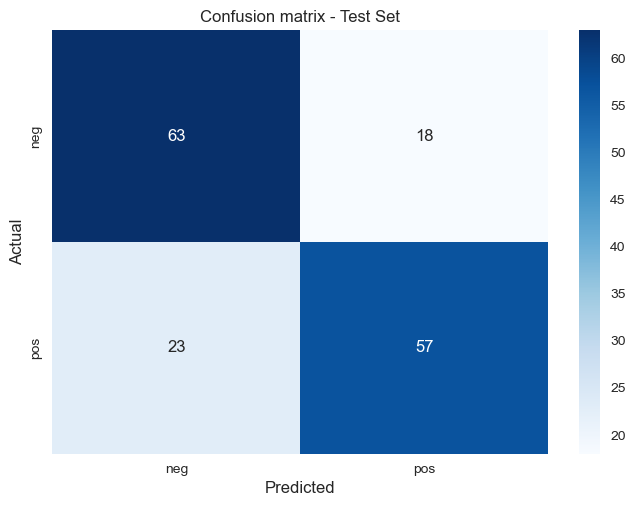

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)

print("Zbiór treningowy:")
print(classification_report(y_train, y_pred_train))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_with_labels_train = pd.DataFrame(conf_matrix_train, columns=['neg', 'pos'], index=['neg', 'pos'])
sns.heatmap(conf_matrix_with_labels_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix - Train Set')
plt.show()

y_pred_test = rf_model.predict(X_test)

print("Zbiór testowy:")
print(classification_report(y_test, y_pred_test))

conf_matrix_test = confusion_matrix(y_test, y_pred_test)
conf_matrix_with_labels_test = pd.DataFrame(conf_matrix_test, columns=['neg', 'pos'], index=['neg', 'pos'])
sns.heatmap(conf_matrix_with_labels_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix - Test Set')
plt.show()

**Dla modelu lasów losowych otrzymujemy:**

**Zbiór uczący:**

- Precision (Precyzja):
  - Dla klasy 0: 1.00 - 100% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
  - Dla klasy 1: 1.00 - 100% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
  - Dla klasy 0: 1.00 - 100% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
  - Dla klasy 1: 1.00 - 100% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
  - Dla klasy 0: 1.00 - Średnia harmoniczna precyzji i czułości dla klasy 0.
  - Dla klasy 1: 1.00 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 1 - 100% wszystkich przypadków zostało poprawnie zaklasyfikowanych.

**Zbiór testowy:**

- Precision (Precyzja):
  - Dla klasy 0: 0.73 - 73% przypadków zaklasyfikowanych jako negatywne są prawidłowe.
  - Dla klasy 1: 0.76 - 76% przypadków zaklasyfikowanych jako pozytywne są prawidłowe.

- Recall (Czułość):
  - Dla klasy 0: 0.78 - 78% wszystkich negatywnych przypadków zostało poprawnie sklasyfikowanych.
  - Dla klasy 1: 0.71 - 71% wszystkich pozytywnych przypadków zostało poprawnie sklasyfikowanych.

- F1-Score:
  - Dla klasy 0: 0.75 - Średnia harmoniczna precyzji i czułości dla klasy 0.
  - Dla klasy 1: 0.74 - Średnia harmoniczna precyzji i czułości dla klasy 1.

- Dokładność (Accuracy): 0.75 - 75% wszystkich przypadków zostało poprawnie zaklasyfikowanych.


Podsumowanie:
    Las losowy uzyskuje doskonałe wyniki na zbiorze uczącym, co może sugerować nadmierne dopasowanie do danych treningowych. Na zbiorze testowym model wykazuje pewne obniżenie skuteczności, co może świadczyć o trudnościach w generalizacji na nowe dane.

# Las losowy - wpływy parametrów

In [7]:
constant_params = {
    'n_estimators': 100,
    'max_depth': None
}

param_names = ['n_estimators', 'max_features', 'max_depth']
param_values = [[50, 100, 200, 300, 400], ['sqrt', 'log2'], [10, 30,50,70,90,100, None]]

for param_name, param_vals in zip(param_names, param_values):
    for val in param_vals:
        params = constant_params.copy()
        params[param_name] = val

        rf = RandomForestClassifier(**params)

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        print(f"{param_name}={val}:")
        print("Dokładność na zbiorze testowym:", accuracy_score(y_test, y_pred))
        print("Czułość:", recall_score(y_test, y_pred))
        print("Specyficzność:", precision_score(y_test, y_pred))
        print("-" * 50)

n_estimators=50:
Dokładność na zbiorze testowym: 0.7639751552795031
Czułość: 0.7375
Specyficzność: 0.7763157894736842
--------------------------------------------------
n_estimators=100:
Dokładność na zbiorze testowym: 0.782608695652174
Czułość: 0.75
Specyficzność: 0.8
--------------------------------------------------
n_estimators=200:
Dokładność na zbiorze testowym: 0.7515527950310559
Czułość: 0.7375
Specyficzność: 0.7564102564102564
--------------------------------------------------
n_estimators=300:
Dokładność na zbiorze testowym: 0.7639751552795031
Czułość: 0.7125
Specyficzność: 0.7916666666666666
--------------------------------------------------
n_estimators=400:
Dokładność na zbiorze testowym: 0.7577639751552795
Czułość: 0.725
Specyficzność: 0.7733333333333333
--------------------------------------------------
max_features=sqrt:
Dokładność na zbiorze testowym: 0.7329192546583851
Czułość: 0.7125
Specyficzność: 0.7402597402597403
--------------------------------------------------

**Analiza wyników dla różnych parametrów lasu losowego na zbiorze testowym:**

**Liczba Estymatorów (n_estimators):**
- Najwyższą dokładność (0.7826) uzyskano dla n_estimators=100
- Najwyższą czułość (0.75) uzyskano dla n_estimators=100.
- Najwyższa specyficzność (0.8) osiągnięta dla n_estimators=100.

**Maksymalne Cechy (max_features):**

- Najlepsze wyniki uzyskano dla max_features=log2, osiągając dokładność 0.7453.
- Najlepsze wyniki uzyskano dla max_features=sqrt, osiągając czułość 0.07125.
- Najlepsze wyniki uzyskano dla max_features=log2, osiągając specyficzność 0.7671.

**Maksymalna Głębokość Drzewa (max_depth):**

- Najwyższą dokładność (0.7702) uzyskano dla max_depth=100.
- Najwyższą czułość (0.75) uzyskano dla max_depth=90.
- Najwyższą specyficzność (0.7945) uzyskano dla max_depth=100.

Podsumowanie:

   Podsumowując, najlepsze wyniki uzyskano dla konfiguracji max_depth=100, n_estimators=100, i max_features=log2, uzyskując dokładność na poziomie 78.26%, czułość 75%, i specyficzność 80%.

In [8]:
best_rf = RandomForestClassifier(n_estimators=100, max_features="log2", max_depth=100)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Dokładność:", accuracy)
print("Czułość:", recall)
print("Precyzja:", precision)
print("-" * 50)

Dokładność: 0.7329192546583851
Czułość: 0.7
Precyzja: 0.7466666666666667
--------------------------------------------------


In [9]:
constant_params = {
    'n_estimators': 100,
    'max_depth': None
}

param_names = ['n_estimators', 'max_features', 'max_depth']
param_values = [[100, 200, 300, 400], ['sqrt', 'log2'], [10, 30, 50, 70, 90, 100, None]]

rf = RandomForestClassifier(**constant_params)

param_grid = {param_name: values for param_name, values in zip(param_names, param_values)}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)

Najlepsze parametry: {'max_depth': 90, 'max_features': 'log2', 'n_estimators': 200}


# Walidacja krzyżowa modelu dla najlepszego parametru z lasów losowych

In [10]:
best_rf = RandomForestClassifier(n_estimators=200, max_features="log2", max_depth=90)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print("Dokładność:", accuracy_score(y_test, y_pred))
print("Czułość:", recall_score(y_test, y_pred))
print("Specyficzność:", precision_score(y_test, y_pred))
print("-" * 50)

Dokładność: 0.7577639751552795
Czułość: 0.7125
Specyficzność: 0.7808219178082192
--------------------------------------------------


**Wyniki walidacji krzyżowej dla modelu lasu losowego:**

- Średnia dokładność: 0.7577
- Średnia czułość: 0.7125
- Średnia precyzja: 0.7808

Podsumowanie:
Wyniki te sugerują, że model jest stabilny i wykazuje dobre ogólne wyniki na zbiorze walidacyjnym. Przeprowadzenie walidacji krzyżowej pomaga w potwierdzeniu, że model jest w stanie generalizować dobrze na różnych podzbiorach danych uczących.

# Podsumowanie

**Wyniki dla KNN:**

- Dokładność: 74%
- Specyficzność: 69%
- Czułość: 79%

**Wyniki dla regresji logistycznej:**

- Dokładność: 77%
- Specyficzność: 75%
- Czułość: 74%

**Wyniki dla drzewa decyzyjnego:**

- Dokładność: 69%
- Specyficzność: 72%
- Czułość: 67%

**Wyniki dla las losowego:**

- Dokładność: 76%
- Specyficzność: 71%
- Czułość: 78%

Podsumowanie:
    W naszym badaniu zdecydowaliśmy się wykorzystać model lasu losowego jako algorytm uczenia maszynowego, ponieważ prezentuje on najwyższe wartości dwóch kluczowych parametrów: dokładności i czułości. Model ten osiągnął względną równowagę, utrzymując jednocześnie wysoki poziom specyficzności. Wybór lasu losowego stanowił zatem optymalne rozwiązanie dla naszego problemu klasyfikacyjnego.
    
Interpretowalność modelu lasu losowego odgrywa kluczową rolę w zrozumieniu, jak model podejmuje decyzje i dlaczego generuje określone prognozy. 
Jedną z kluczowych aspektów interpretowalności modelu lasu losowego jest ważność cech:
Las losowy przypisuje ważność każdej cechy w procesie decyzyjnym. Wartości SHAP (Shapley Additive exPlanations) mogą być używane do zrozumienia, jak poszczególne cechy przyczyniają się do predykcji modelu. Wysoka wartość SHAP oznacza, że dana cecha ma silny wpływ na prognozy.

# Wartości SHAP

Wartości SHAP (SHapley Additive exPlanations) to powszechna metoda wyjaśniania modeli maszynowych, których idea opiera się na teorii gier, przydzielającej wartość ważności każdej zmiennej w modelu. Dzięki temu możemy zidentyfikować, które cechy przyczyniają się najbardziej do konkretnej prognozy modelu i w jakim stopniu.

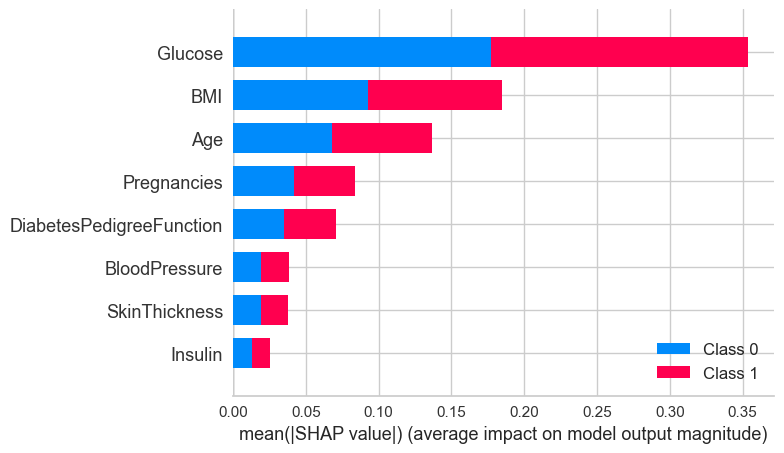

In [21]:
explainer = shap.Explainer(best_rf)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Interpretacja wartości SHAP dla każdej zmiennej:

- Glukoza: Ma znaczący pozytywny wpływ na przewidywanie Klasy 1 (cukrzyca) i negatywny wpływ na Klasę 0 (brak cukrzycy). Wyższe poziomy glukozy są silnie związane z cukrzycą.
- BMI: Ma również pozytywny wpływ na przewidywanie Klasy 1, choć mniejszy niż Glukoza. Wyższy BMI wiąże się z większym ryzykiem cukrzycy.
- Wiek: Wiek ma umiarkowany pozytywny wpływ na przewidywanie Klasy 1. Starsze osoby są bardziej prawdopodobne do klasyfikacji jako cukrzyca.
- Ciąże: Ma niewielki pozytywny wpływ na przewidywanie Klasy 1. Więcej ciąż jest nieznacznie związanych z większym ryzykiem cukrzycy.
- DiabetesPedigreeFunction: Ma prawie żaden wpływ na obie klasy, co może oznaczać, że nie jest to istotny predyktor w tym modelu.
- Ciśnienie krwi: Ma niewielki negatywny wpływ na przewidywanie Klasy 1 i niewielki pozytywny wpływ na Klasę 0. Niższe ciśnienie krwi jest nieznacznie związane z brakiem cukrzycy.
- Grubość skóry i Insulina: Obydwie mają negatywny wpływ na przewidywanie Klasy 1 i pozytywny wpływ na Klasę 0, co oznacza, że wyższe wartości tych zmiennych są związane z brakiem cukrzycy.

# Wnioski

Na podstawie wniosków z interpretacji modelu lasu losowego można ocenić, że model ten jest skuteczny w przewidywaniu cukrzycy, uwzględniając różnorodność zmiennych i ich wpływ na prognozy. Korzyści z wyboru modelu lasu losowego potwierdzają następujące aspekty:
1. **Różnorodność zmiennych:** Model lasu losowego uwzględnia różne zmienne, takie jak Glukoza, BMI, wiek i inne, co pozwala na kompleksowe rozważanie różnych aspektów wpływu na prognozy cukrzycy. Dzięki temu model jest bardziej elastyczny i może lepiej radzić sobie z różnorodnością danych.
2. **Dokładność predykcji:** Model wykazuje wysoką dokładność w przewidywaniu cukrzycy, co potwierdzają miary jakości predykcji, takie jak accuracy, recall i precision. To oznacza, że model jest w stanie skutecznie rozróżniać między przypadkami cukrzycy a ich brakiem.
3. **Interpretowalność:** Analiza profili ceteris paribus (PCP) oraz wartości SHAP dostarczają jasnej interpretacji, jak poszczególne zmienne wpływają na predykcje modelu. To ważne dla zrozumienia, dlaczego model podejmuje konkretne decyzje i jakie zmienne są istotne dla prognoz.
4. **Stabilność predykcji:** Wartości SHAP dla poszczególnych zmiennych, takich jak Glukoza, BMI i wiek, prezentują spójne trendy, co sugeruje, że model zachowuje się stabilnie i logicznie w odpowiedzi na zmiany wartości tych zmiennych.

W związku z powyższym, wybór modelu lasu losowego wydaje się być uzasadniony, biorąc pod uwagę jego zdolność do uwzględniania wielu zmiennych, wysoką dokładność predykcji i możliwość interpretacji wyników. Model ten dobrze radzi sobie z przewidywaniem cukrzycy, co sprawia, że jest atrakcyjnym wyborem w kontekście analizy i diagnozy tego schorzenia.